In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [30]:
from torch.utils.data import Dataset

In [ ]:
A1,A2,A3 = 60 * torch.rand(3,4500)

In [31]:
torch.randn(dataset.fx.shape).shape

torch.Size([100, 120])

In [32]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset


class time_series_paper(Dataset):
    """synthetic time series dataset from section 5.1"""
    
    def __init__(self,t0=96,N=4500,transform=None):
        """
        Args:
            t0: previous t0 data points to predict from
            N: number of data points
            transform: any transformations to be applied to time series
        """
        self.t0 = t0
        self.N = N
        self.transform = None
        
        # time points
        self.x = torch.cat(N*[torch.arange(0,t0+24).type(torch.float).unsqueeze(0)])

        # sinuisoidal signal
        A1,A2,A3 = 60 * torch.rand(3,N)
        A4 = torch.max(A1,A2)        
        self.fx = torch.cat([A1.unsqueeze(1)*torch.sin(np.pi*self.x[0,0:12]/6)+72 ,
                        A2.unsqueeze(1)*torch.sin(np.pi*self.x[0,12:24]/6)+72 ,
                        A3.unsqueeze(1)*torch.sin(np.pi*self.x[0,24:t0]/6)+72,
                        A4.unsqueeze(1)*torch.sin(np.pi*self.x[0,t0:t0+24]/12)+72],1)
        
        # add noise
        self.fx = self.fx + torch.randn(self.fx.shape)
        
        self.masks = self._generate_square_subsequent_mask(24+1)
                
        
        # print out shapes to confirm desired output
        print("x: {}*{}".format(*list(self.x.shape)),
              "fx: {}*{}".format(*list(self.fx.shape)))        
        
    def __len__(self):
        return len(self.fx)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        #sample = {"x":self.x[idx,0:self.t0],
        #          "x_next":self.x[idx,self.t0:self.t0+24],
        #          "fx": self.fx[idx,0:self.t0],
        #          "fx_next":self.fx[idx,self.t0:self.t0+24],
        #          "attention_masks":self.masks}
        
        sample = (self.x[idx,0:self.t0-1],
                  self.x[idx,self.t0-1:self.t0+24],
                  self.fx[idx,0:self.t0-1],
                  self.fx[idx,self.t0-1:self.t0+24],
                  self.masks)
        
        if self.transform:
            sample=self.transform(sample)
            
        return sample
    
    def _generate_square_subsequent_mask(self,sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [43]:
d = time_series_paper(t0=96,N=4500)
for i in d[0]:
    print(i.shape)

x: 4500*120 fx: 4500*120
torch.Size([95])
torch.Size([25])
torch.Size([95])
torch.Size([25])
torch.Size([25, 25])


In [45]:
d.x.shape

torch.Size([4500, 120])

In [33]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset


class time_series_decoder_paper(Dataset):
    """synthetic time series dataset from section 5.1"""
    
    def __init__(self,t0=96,N=4500,transform=None):
        """
        Args:
            t0: previous t0 data points to predict from
            N: number of data points
            transform: any transformations to be applied to time series
        """
        self.t0 = t0
        self.N = N
        self.transform = None
        
        # time points
        self.x = torch.cat(N*[torch.arange(0,t0+24).type(torch.float).unsqueeze(0)])

        # sinuisoidal signal
        A1,A2,A3 = 60 * torch.rand(3,N)
        A4 = torch.max(A1,A2)        
        self.fx = torch.cat([A1.unsqueeze(1)*torch.sin(np.pi*self.x[0,0:12]/6)+72 ,
                        A2.unsqueeze(1)*torch.sin(np.pi*self.x[0,12:24]/6)+72 ,
                        A3.unsqueeze(1)*torch.sin(np.pi*self.x[0,24:t0]/6)+72,
                        A4.unsqueeze(1)*torch.sin(np.pi*self.x[0,t0:t0+24]/12)+72],1)
        
        # add noise
        self.fx = self.fx + torch.randn(self.fx.shape)
        
        self.masks = self._generate_square_subsequent_mask(t0)
                
        
        # print out shapes to confirm desired output
        print("x: {}*{}".format(*list(self.x.shape)),
              "fx: {}*{}".format(*list(self.fx.shape)))        
        
    def __len__(self):
        return len(self.fx)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        sample = (self.x[idx,:],
                  self.fx[idx,:],
                  self.masks)
        
        if self.transform:
            sample=self.transform(sample)
            
        return sample
    
    def _generate_square_subsequent_mask(self,t0):
        mask = torch.zeros(t0+24,t0+24)
        for i in range(0,t0):
            mask[i,t0:] = 1 
        for i in range(t0,t0+24):
            mask[i,i+1:] = 1
        mask = mask.float().masked_fill(mask == 1, float('-inf'))#.masked_fill(mask == 1, float(0.0))
        return mask

In [34]:
d = time_series_decoder_paper(96,100)

x: 100*120 fx: 100*120


In [35]:
class time_series_missing_paper(Dataset):
    """synthetic time series dataset from section 5.1"""
    
    def __init__(self,t0=96,N=4500,missing_chunk=50,transform=None):
        """
        Args:
            t0: previous t0 data points to predict from
            N: number of data points
            transform: any transformations to be applied to time series
        """
        self.t0 = t0
        self.N = N
        self.transform = None
        
        # time points
        self.x = torch.cat(N*[torch.arange(0,t0+24).type(torch.float).unsqueeze(0)])

        # sinuisoidal signal
        A1,A2,A3 = 60 * torch.rand(3,N)
        A4 = torch.max(A1,A2)        
        self.fx = torch.cat([A1.unsqueeze(1)*torch.sin(np.pi*self.x[0,0:12]/6)+72 ,
                        A2.unsqueeze(1)*torch.sin(np.pi*self.x[0,12:24]/6)+72 ,
                        A3.unsqueeze(1)*torch.sin(np.pi*self.x[0,24:t0]/6)+72,
                        A4.unsqueeze(1)*torch.sin(np.pi*self.x[0,t0:t0+24]/12)+72],1)
        
        # add noise
        self.fx = self.fx + torch.randn(self.fx.shape)
        

        src_mask = torch.zeros(t0-1,t0-1)
        
        self.fx_missing = torch.zeros((N,t0+24-missing_chunk)) 
        self.x_missing = torch.zeros((N,t0+24-missing_chunk)) 
        
        self.x_prior = torch.zeros((N,t0-1-missing_chunk))
        self.x_post = torch.zeros((N,1+24))
        self.fx_prior = torch.zeros((N,t0-1-missing_chunk))
        self.fx_post = torch.zeros((N,1+24))
        
        for j in range(0,self.fx.shape[0]):
            missing_idx = torch.randint(24,t0-1-missing_chunk,(1,)).item()
            desired_idx = torch.LongTensor([i for i in np.arange(0,t0+24) if i not in np.arange(missing_idx,missing_idx+missing_chunk)])
            
            
            self.fx_missing[j,:] = self.fx[j,desired_idx]
            self.x_missing[j,:] = self.x[j,desired_idx]
                        
            idx1 = desired_idx[desired_idx < (t0-1)].squeeze()
            idx2 = desired_idx[desired_idx >= (t0-1)].squeeze()

            self.x_prior[j,:] = self.x[j,idx1]
            self.x_post[j,:] = self.x[j,idx2]
            self.fx_prior[j,:] = self.fx[j,idx1]
            self.fx_post[j,:] = self.fx[j,idx2]
        
            
        self.masks = self._generate_square_subsequent_mask(24+1)
        
                
        
        # print out shapes to confirm desired output
        print("x: {}*{}".format(*list(self.x.shape)),
              "fx: {}*{}".format(*list(self.fx.shape)))        
        
    def __len__(self):
        return len(self.fx)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        #sample = {"x":self.x[idx,0:self.t0],
        #          "x_next":self.x[idx,self.t0:self.t0+24],
        #          "fx": self.fx[idx,0:self.t0],
        #          "fx_next":self.fx[idx,self.t0:self.t0+24],
        #          "attention_masks":self.masks}
        
        sample = (self.x_prior[idx],
                  self.x_post[idx],
                  self.fx_prior[idx],
                  self.fx_post[idx],
                  self.masks)
        
        if self.transform:
            sample=self.transform(sample)
            
        return sample
    
    def _generate_square_subsequent_mask(self,sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [36]:
t0 = 96
N = 100

# Missing Dataset

In [19]:
dataset_missing = time_series_missing_paper()

x: 4500*120 fx: 4500*120


In [39]:
type(dataset[0]), len(dataset[0])

(tuple, 5)

In [40]:
dataset[0][0].shape

torch.Size([95])

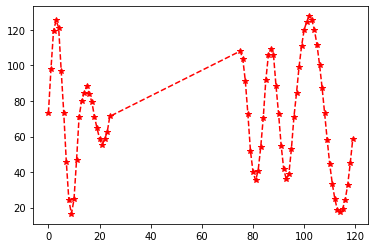

In [20]:
idx = torch.randint(0,N,(1,)).item()
plt.plot(dataset_missing.x_missing[idx].numpy(),dataset_missing.fx_missing[idx].numpy(),'r*--')
plt.show()

# Regular dataset

In [21]:
dataset_missing.fx[99]

tensor([ 72.8295,  73.5245,  74.7984,  74.1415,  73.2073,  73.4908,  71.7879,
         70.8831,  70.7308,  68.0286,  71.8613,  71.2016,  71.0458,  96.7696,
        112.7200, 120.8598, 115.2737,  96.9500,  70.8707,  48.7085,  29.7213,
         22.5188,  27.8213,  48.3033,  72.1119,  81.6531,  87.2400,  91.8366,
         88.5194,  81.7482,  71.1553,  62.9805,  55.8882,  52.3852,  54.0878,
         61.4652,  71.8208,  82.5104,  88.4668,  90.1301,  89.5464,  82.5761,
         72.9225,  60.9740,  56.4931,  53.0304,  54.7080,  62.6593,  73.1398,
         81.9693,  89.2575,  90.3448,  88.6700,  82.3623,  72.6812,  63.3696,
         53.2528,  52.7857,  54.2426,  61.3543,  72.3533,  82.9321,  88.4881,
         91.5529,  88.1596,  83.3175,  72.4591,  61.8287,  55.4526,  52.0894,
         55.3965,  63.7648,  72.7994,  79.2860,  89.2381,  90.5077,  88.1461,
         80.6462,  71.5816,  62.6969,  53.8828,  53.3110,  55.2468,  63.9874,
         70.3729,  80.9406,  89.4849,  90.2516,  88.0518,  81.63

In [22]:
dataset = time_series_paper(t0,N)

x: 100*120 fx: 100*120


In [23]:
dataset.masks

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf],
        [0., 0., 0., 0., 0.,

In [24]:
dataset.fx

tensor([[ 71.7467,  74.6329,  77.8675,  ...,  69.5616,  68.5531,  70.3145],
        [ 74.9648,  84.4731,  90.1656,  ...,  29.2930,  41.4963,  58.3953],
        [ 71.9067,  96.1720, 114.1336,  ...,  38.1502,  49.0317,  60.2073],
        ...,
        [ 71.6666,  99.7077, 116.8088,  ...,  35.1701,  45.7109,  56.3788],
        [ 71.1646,  99.0180, 117.7780,  ...,  31.7488,  43.7702,  57.7814],
        [ 73.0724,  79.3233,  86.7134,  ...,  43.8031,  51.5965,  62.2741]])

In [25]:
dataset.x

tensor([[  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        ...,
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.]])

In [26]:
dataset[0]

(tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
         28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
         42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
         56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
         70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
         84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94.]),
 tensor([ 95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106.,
         107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118.,
         119.]),
 tensor([71.7467, 74.6329, 77.8675, 77.1782, 76.2794, 73.2956, 73.7730, 69.9841,
         67.2659, 68.3551, 66.8620, 69.5718, 72.9755, 74.5708, 75.7769, 77.2048,
         74.6790, 72.7502, 72.8267, 69.8021, 68.6988, 67.7072, 66.4909, 68.9228,
         70.8219, 85.5505, 95.6766, 98

In [27]:
encoded_dict =  dataset[0:1]

In [28]:
for key,value in encoded_dict.items():
    print("{}: ".format(key),value.shape)

AttributeError: 'tuple' object has no attribute 'items'

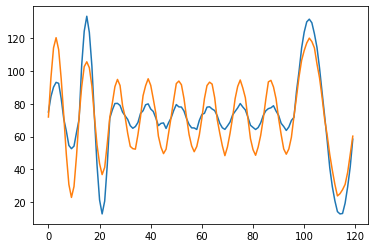

In [29]:
plt.plot(dataset.x[1].numpy(),dataset.fx[1].numpy())
plt.plot(dataset.x[2].numpy(),dataset.fx[2].numpy())
plt.show()